### Flux/magnitude detection limit of galaxies in DC2

In this notebook, we aim to find the faintest flux/magnitude at which galaxies are visible in DC2 images.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

---

We load in one of the 4096 $\times$ 4096 images.

In [2]:
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.surveys.dc2 import wcs_from_wcs_header_str, DC2FullCatalog

with initialize(config_path="../../", version_base = None):
    cfg = compose("lensing_config")

In [3]:
dc2 = instantiate(cfg.surveys.dc2)
dc2._load_image_and_bg_files_list()

98

In [4]:
# this cell takes 10-20 seconds
image_index = 34
image, wcs_header_str = dc2.read_image_for_bands(image_index)
wcs = wcs_from_wcs_header_str(wcs_header_str)

plocs_lim = image[0].shape
height = plocs_lim[0]
width = plocs_lim[1]

In [5]:
catalog = pd.read_pickle(dc2.dc2_cat_path)

galid = torch.from_numpy(catalog["galaxy_id"].values)
ra = torch.from_numpy(catalog["ra"].values)
dec = torch.from_numpy(catalog["dec"].values)

shear1 = torch.from_numpy(catalog["shear_1"].values)
shear2 = torch.from_numpy(catalog["shear_2"].values)
complex_shear = shear1 + shear2 * 1j
convergence = torch.from_numpy(catalog["convergence"].values)
reduced_shear = complex_shear / (1.0 - convergence)

ellip1_intrinsic = torch.from_numpy(catalog["ellipticity_1_true"].values)
ellip2_intrinsic = torch.from_numpy(catalog["ellipticity_2_true"].values)
complex_ellip_intrinsic = ellip1_intrinsic + ellip2_intrinsic * 1j
complex_ellip_lensed = (complex_ellip_intrinsic + reduced_shear) / (
    1.0 + reduced_shear.conj() * complex_ellip_intrinsic
)
ellip1_lensed = torch.view_as_real(complex_ellip_lensed)[..., 0]
ellip2_lensed = torch.view_as_real(complex_ellip_lensed)[..., 1]

redshift = torch.from_numpy(catalog["redshift"].values)

flux_r = torch.from_numpy(catalog["flux_r"].values)
mag_r = torch.from_numpy(catalog["mag_r"].values)

_, psf_params = DC2FullCatalog.get_bands_flux_and_psf(dc2.bands, catalog)

plocs = DC2FullCatalog.plocs_from_ra_dec(ra, dec, wcs).squeeze(0)
x0_mask = (plocs[:, 0] > 0) & (plocs[:, 0] < height)
x1_mask = (plocs[:, 1] > 0) & (plocs[:, 1] < width)
plocs_mask = x0_mask * x1_mask

galid = galid[plocs_mask]
plocs = plocs[plocs_mask]

shear1 = shear1[plocs_mask]
shear2 = shear2[plocs_mask]
convergence = convergence[plocs_mask]
ellip1_lensed = ellip1_lensed[plocs_mask]
ellip2_lensed = ellip2_lensed[plocs_mask]

redshift = redshift[plocs_mask]

flux_r = flux_r[plocs_mask]
mag_r = mag_r[plocs_mask]

nobj = galid.shape[0]

Now we examine an 80 $\times$ 80 subimage and plot the true galaxy locations, colored by different flux cutpoints:

In [6]:
hmin = 300
hmax = 380
wmin = 300
wmax = 380

In [7]:
subset_filter = (plocs[:,0] > hmin) & (plocs[:,0] < hmax) & (plocs[:,1] > wmin) & (plocs[:,1] < wmax)

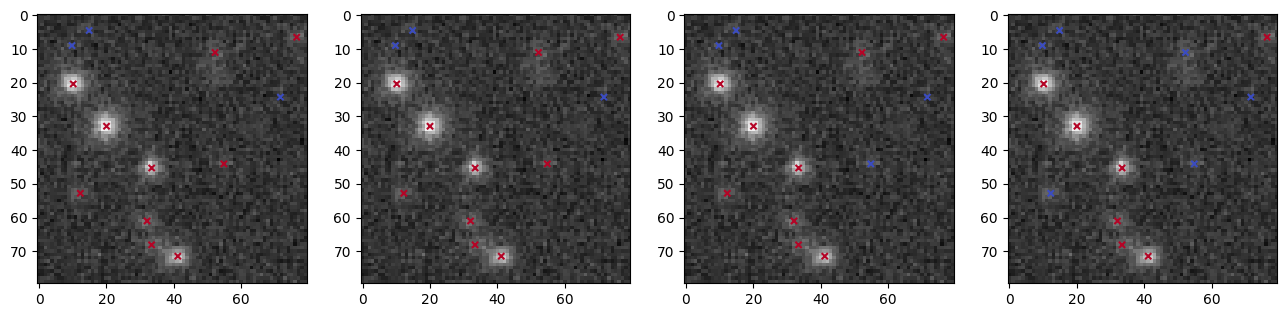

In [8]:
fig, ax = plt.subplots(1, 4, figsize = (16,4))
_ = ax[0].imshow((image[2][hmin:hmax,wmin:wmax] - image[2].min() + 10).log(), cmap = 'gray')
_ = ax[1].imshow((image[2][hmin:hmax,wmin:wmax] - image[2].min() + 10).log(), cmap = 'gray')
_ = ax[2].imshow((image[2][hmin:hmax,wmin:wmax] - image[2].min() + 10).log(), cmap = 'gray')
_ = ax[3].imshow((image[2][hmin:hmax,wmin:wmax] - image[2].min() + 10).log(), cmap = 'gray')

# r-band flux >= 50
_ = ax[0].scatter(plocs[:,1][subset_filter] - 0.5 - wmin,
                  plocs[:,0][subset_filter] - 0.5 - hmin,
                  marker = 'x', c = flux_r[subset_filter] >= 50, s = 20, cmap = 'coolwarm')
# r-band flux >= 100
_ = ax[1].scatter(plocs[:,1][subset_filter] - 0.5 - wmin,
                  plocs[:,0][subset_filter] - 0.5 - hmin,
                  marker = 'x', c = flux_r[subset_filter] >= 100, s = 20, cmap = 'coolwarm')
# r-band flux >= 150
_ = ax[2].scatter(plocs[:,1][subset_filter] - 0.5 - wmin,
                  plocs[:,0][subset_filter] - 0.5 - hmin,
                  marker = 'x', c = flux_r[subset_filter] >= 150, s = 20, cmap = 'coolwarm')
# r-band flux >= 200
_ = ax[3].scatter(plocs[:,1][subset_filter] - 0.5 - wmin,
                  plocs[:,0][subset_filter] - 0.5 - hmin,
                  marker = 'x', c = flux_r[subset_filter] >= 200, s = 20, cmap = 'coolwarm')

Here's the relationship between flux and mag in the r-band:

In [9]:
mag_r[(flux_r - 150).abs().argmin()]

tensor(25.9597)

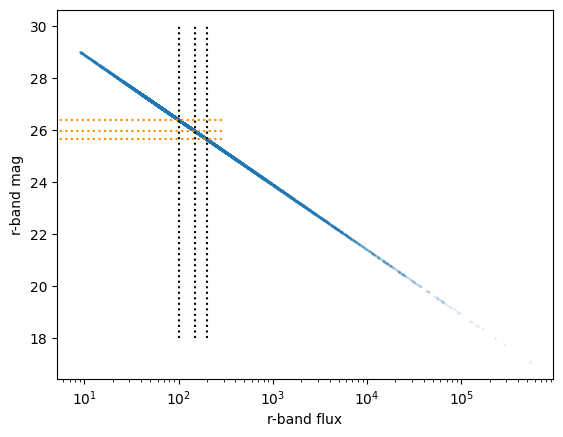

In [10]:
_ = plt.scatter(flux_r, mag_r, alpha = 0.1, s = 1)
_ = plt.xscale('log')
_ = plt.xlabel('r-band flux')
_ = plt.ylabel('r-band mag')
_ = plt.vlines(x = 100, ymin = 18, ymax = 30, color = 'black', linestyle = ':')
_ = plt.vlines(x = 150, ymin = 18, ymax = 30, color = 'black', linestyle = ':')
_ = plt.vlines(x = 200, ymin = 18, ymax = 30, color = 'black', linestyle = ':')
_ = plt.hlines(y = mag_r[(flux_r - 100).abs().argmin()].item(), xmin = 0, xmax = 300, color = 'darkorange', linestyle = ':')
_ = plt.hlines(y = mag_r[(flux_r - 150).abs().argmin()].item(), xmin = 0, xmax = 300, color = 'darkorange', linestyle = ':')
_ = plt.hlines(y = mag_r[(flux_r - 200).abs().argmin()].item(), xmin = 0, xmax = 300, color = 'darkorange', linestyle = ':')

Shear and convergence maps if we filter r-band flux by 50 versus if we filter it by 200:

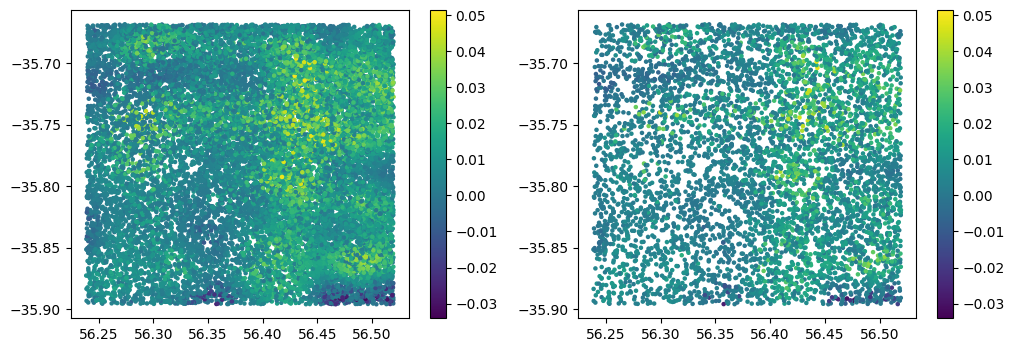

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (12,4))

vmin = min(shear1[flux_r >= 50].min(), shear1[flux_r >= 200].min())
vmax = max(shear1[flux_r >= 50].max(), shear1[flux_r >= 200].max())

tmp = ax[0].scatter(ra[plocs_mask][flux_r >= 50],
                dec[plocs_mask][flux_r >= 50],
                c = shear1[flux_r >= 50],
                alpha = 1.0, s = 5, vmin = vmin, vmax = vmax)
_ = plt.colorbar(tmp)

tmp = ax[1].scatter(ra[plocs_mask][flux_r >= 200],
                dec[plocs_mask][flux_r >= 200],
                c = shear1[flux_r >= 200],
                alpha = 1.0, s = 5, vmin = vmin, vmax = vmax)
_ = plt.colorbar(tmp)

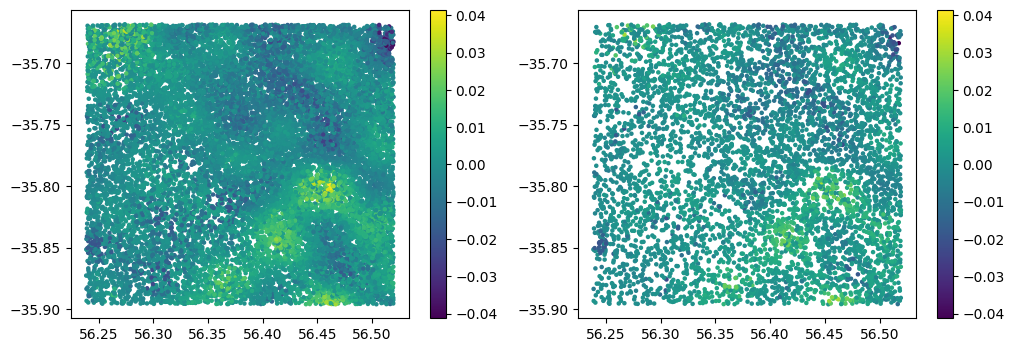

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (12,4))

vmin = min(shear2[flux_r >= 50].min(), shear2[flux_r >= 200].min())
vmax = max(shear2[flux_r >= 50].max(), shear2[flux_r >= 200].max())

tmp = ax[0].scatter(ra[plocs_mask][flux_r >= 50],
                dec[plocs_mask][flux_r >= 50],
                c = shear2[flux_r >= 50],
                alpha = 1.0, s = 5, vmin = vmin, vmax = vmax)
_ = plt.colorbar(tmp)

tmp = ax[1].scatter(ra[plocs_mask][flux_r >= 200],
                dec[plocs_mask][flux_r >= 200],
                c = shear2[flux_r >= 200],
                alpha = 1.0, s = 5, vmin = vmin, vmax = vmax)
_ = plt.colorbar(tmp)

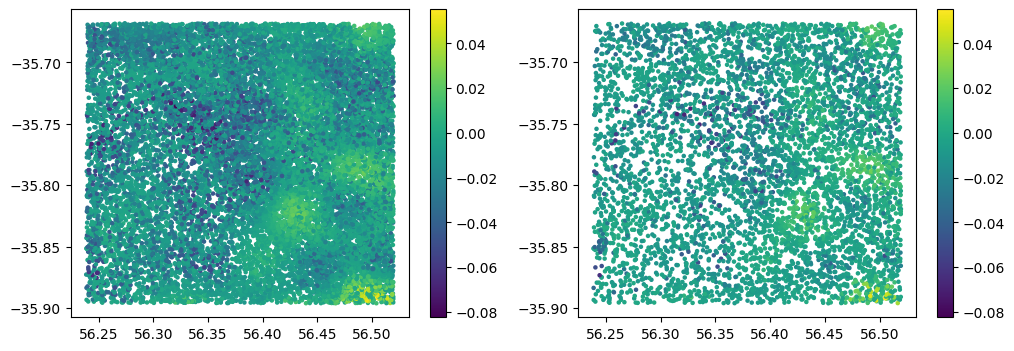

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12,4))

vmin = min(convergence[flux_r >= 50].min(), convergence[flux_r >= 200].min())
vmax = max(convergence[flux_r >= 50].max(), convergence[flux_r >= 200].max())

tmp = ax[0].scatter(ra[plocs_mask][flux_r >= 50],
                dec[plocs_mask][flux_r >= 50],
                c = convergence[flux_r >= 50],
                alpha = 1.0, s = 5, vmin = vmin, vmax = vmax)
_ = plt.colorbar(tmp)

tmp = ax[1].scatter(ra[plocs_mask][flux_r >= 200],
                dec[plocs_mask][flux_r >= 200],
                c = convergence[flux_r >= 200],
                alpha = 1.0, s = 5, vmin = vmin, vmax = vmax)
_ = plt.colorbar(tmp)